In [148]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
import corner
import scipy.integrate as integrate
%matplotlib inline
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)
text_size = 16

## Part (a)

In [14]:
#set minimum and maximum mass values 
m_min = 0.5
m_max = 0.8
#Chabrier IMF function given in the problem
def ln_imf(m):
    xi = (0.15/m)*np.exp(-(np.log(m)-np.log(0.08))**2/(2*0.69**2))
    return np.log(xi)
def imf(m):
    xi = (0.15/m)*np.exp(-(np.log(m)-np.log(0.08))**2/(2*0.69**2))
    return xi

In [113]:
def lnprior(m, m_min, m_max):
    """Assume a flat, top hat prior that peaks between the min and max mass values."""
    if m_min <= m <= m_max: 
        return 0.0 
    return -np.inf

def lnprob(m):
    """Combine the flat prior with the likelihood function (which is the provided IMF function.)"""
    lp = lnprior(m, m_min, m_max)
    if not np.isfinite(lp):
        return -np.inf
    return lp + ln_imf(m)    

#set up emcee where I initialize each walker at a random mass within the possible range
ndim, nwalkers = 1, 100
steps = 1000
p0 = [np.random.rand(ndim)*(m_max-m_min)+m_min for i in range(nwalkers)] 
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)
#burn in, then continue
pos, prob, state = sampler.run_mcmc(p0, 100)
sampler.reset()
sampler.run_mcmc(pos, steps)
#the mass list is the flatchain of values, which combines the steps from each walker
mass_list = sampler.flatchain

In [114]:
#create histogram from list of masses to use to fit the power law
hist, bin_edges = np.histogram(mass_list, bins = 30)
mass = (bin_edges[:-1]+bin_edges[1:])/2

The autocorrelation time is  [ 40.62330189]


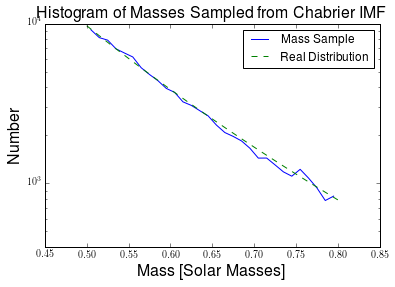

In [121]:
print 'The autocorrelation time is ', emcee.autocorr.integrated_time(sampler.flatchain)

#plot the true distribution to see how it compares to the sample
func_mass = np.linspace(0.5, 0.8, 100)
func_imf = []
for i in func_mass:
    func_imf.append(imf(i)*1100000)

plt.figure(1)
plt.semilogy(mass, hist, label = 'Mass Sample')
plt.semilogy(func_mass, func_imf, '--', label = 'Real Distribution')
plt.ylim(4e2,1e4)
plt.xlabel(r'Mass [Solar Masses]', fontsize = text_size)
plt.ylabel(r'Number', fontsize = text_size)
plt.title(r'Histogram of Masses Sampled from Chabrier IMF', fontsize = text_size)
plt.legend()
plt.savefig('histogram_of_masses_chabrier_prob4.png',dpi = 300)

Here is it clear that the masses are sampled over the range of 0.5-0.8 solar masses.


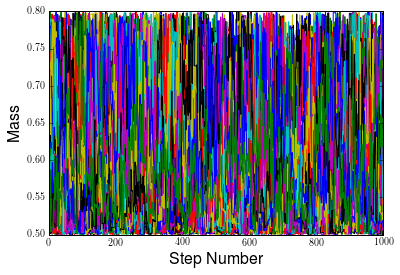

In [117]:
#mass vs. Step Number
plt.figure(3)
[plt.plot(sampler.chain[i,]) for i in range(100)]
plt.xlabel(r'Step Number', fontsize = text_size)
plt.ylabel(r'Mass', fontsize = text_size)
#plt.savefig("m_step_emcee.png", dpi=300)
print 'Here is it clear that the masses are sampled over the range of 0.5-0.8 solar masses.'

## Part (b)
Now, using the masses that I generated using emcee, I will use emcee to fit a power law
slope and normalization constant to the mass list.

In [159]:
#first attempt
"""
N = 1000
def ln_prob(theta, mass, hist):
    a, c= theta
    #work in log space so that it simplifies the fit to a line
    mass = np.log(mass)
    hist = np.log(hist)
    if c <= 0:
        return -np.inf
    model = np.log(c)-a*mass
    #model = c*(mass**(-a))
    #find the least square between the data and the model using the test a and c
    #return -np.sum((hist - model)**2)
    return np.sum(model)
"""
N = 1000
def ln_prob(theta, mass, hist):
    a= theta
    const = 1/(integrate.quad(lambda x: x**(-a),m_min, m_max))[0]
    #force a to be greater than 1
    if a <=1:
        return -np.inf
    model = np.log(const*(mass**(-a)))
    #find the least square between the data and the model using the test a and c
    return np.sum(model)
"""set up emcee with 1 dimensions and 100 walkers to try and fit the slope 
given the binned mass and number per bin"""

ndim2, nwalkers2 = 1, 100
pos = [np.random.rand(ndim2) for i in range(nwalkers2)] 
sampler2 = emcee.EnsembleSampler(nwalkers2, ndim2, ln_prob, args=(mass, hist))
sampler2.run_mcmc(pos, N)

(array([[ 1.04984188],
        [ 1.90927735],
        [ 2.27528581],
        [ 1.37963713],
        [ 1.30059974],
        [ 1.48754114],
        [ 2.61361402],
        [ 1.04143415],
        [ 2.12391204],
        [ 3.37492504],
        [ 1.49768903],
        [ 4.22056327],
        [ 1.09180397],
        [ 1.23265114],
        [ 1.11553893],
        [ 1.4829848 ],
        [ 1.51195639],
        [ 3.52440793],
        [ 2.35753557],
        [ 1.34115792],
        [ 2.63024701],
        [ 1.31749592],
        [ 1.43581934],
        [ 2.26618602],
        [ 1.78731128],
        [ 1.0775423 ],
        [ 1.50441616],
        [ 2.0358416 ],
        [ 1.40027494],
        [ 2.14399019],
        [ 1.23201824],
        [ 1.94672741],
        [ 1.04439056],
        [ 1.23247361],
        [ 1.47013099],
        [ 2.02470985],
        [ 2.63378832],
        [ 3.67974951],
        [ 2.33643915],
        [ 1.3438557 ],
        [ 1.87239163],
        [ 2.63932046],
        [ 1.70506242],
        [ 1

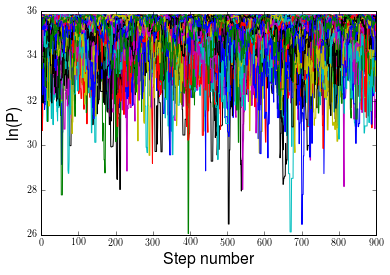

In [167]:
#ln(p) vs. step number
plt.figure(4)
[plt.plot(sampler2.lnprobability[i,100:]) for i in range(100)]
plt.xlabel(r'Step number', fontsize = text_size)
plt.ylabel(r'ln(P)', fontsize = text_size)
#plt.savefig("lnp_step_emcee_prob4.png", dpi=300)

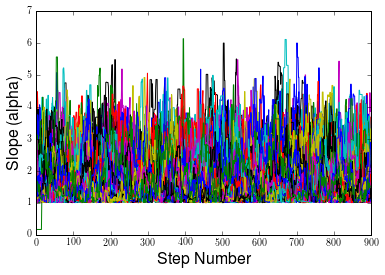

In [178]:
#slope vs. step number
plt.figure(5)
[plt.plot(sampler2.chain[i,100:,0]) for i in range(100)]
plt.xlabel(r'Step Number', fontsize = text_size)
plt.ylabel(r'Slope (alpha)', fontsize = text_size)
plt.savefig("slope_step_emcee_prob4.png", dpi=300)

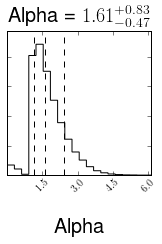

In [166]:
corner_plot = corner.corner(sampler2.flatchain[100:,:], labels = ['Alpha'], show_titles = True,\
              plot_contours = True, quantiles = [0.16,0.5,0.84], label_kwargs={"fontsize": 20},
                            title_kwargs={"fontsize": 20})
corner_plot.show()
corner_plot.savefig("corner_plot_emcee_prob4.png", dpi=300)

Kroupa had an alpha slope of 2.3 for mass greater than 0.5 solar masses. The value
I found it around alpha = 1.61. This is lower than the Kroupa IMF and likely
is a result of wrongly trying to fit a power law to a distribution that is actually
log normal.